In [1]:
cd ..

/home/aiteam/tykim/generative/gan/PTI


In [2]:
import os
import sys
import pickle
import numpy as np
from PIL import Image
import torch
from configs import paths_config, hyperparameters, global_config
from utils.align_data import pre_process_images
from scripts.run_pti import run_PTI
from IPython.display import display
import matplotlib.pyplot as plt
from scripts.latent_editor_wrapper import LatentEditorWrapper

In [3]:
use_multi_id_training = False
global_config.device = 'cuda'
paths_config.e4e = '/home/aiteam/tykim/generative/gan/PTI/pretrained_models/e4e_ffhq_encode.pt'
paths_config.input_data_id = 'iu'
paths_config.input_data_path = f'/home/aiteam/tykim/generative/gan/PTI/images/aligned'
paths_config.stylegan2_ada_ffhq = '/home/aiteam/tykim/generative/gan/PTI/pretrained_models/ffhq.pkl'
paths_config.checkpoints_dir = '/home/aiteam/tykim/generative/gan/PTI/checkpoints'
paths_config.style_clip_pretrained_mappers = '/home/aiteam/tykim/generative/gan/PTI/pretrained_models'
hyperparameters.use_locality_regularization = False

In [4]:
from random import choice
from string import ascii_uppercase
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
import os
from configs import global_config, paths_config
import wandb

from training.coaches.multi_id_coach import MultiIDCoach
from training.coaches.single_id_coach import SingleIDCoach
from utils.ImagesDataset import ImagesDataset

In [5]:
paths_config.input_data_path = '/home/aiteam/tykim/generative/gan/PTI/images/iu-1'

dataset = ImagesDataset(paths_config.input_data_path, transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])]))

In [6]:
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
coach = SingleIDCoach(dataloader, False)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/aiteam/miniconda3/envs/eg3d/lib/python3.9/site-packages/lpips/weights/v0.1/alex.pth


In [7]:
noise_bufs = {name: buf for (name, buf) in coach.G.synthesis.named_buffers() if 'noise_const' in name}

In [8]:
torch.zeros([])

tensor(0.)

In [9]:
for (name, buf) in coach.G.synthesis.named_buffers():
  print(name)

b4.resample_filter
b4.conv1.resample_filter
b4.conv1.noise_const
b8.resample_filter
b8.conv0.resample_filter
b8.conv0.noise_const
b8.conv1.resample_filter
b8.conv1.noise_const
b16.resample_filter
b16.conv0.resample_filter
b16.conv0.noise_const
b16.conv1.resample_filter
b16.conv1.noise_const
b32.resample_filter
b32.conv0.resample_filter
b32.conv0.noise_const
b32.conv1.resample_filter
b32.conv1.noise_const
b64.resample_filter
b64.conv0.resample_filter
b64.conv0.noise_const
b64.conv1.resample_filter
b64.conv1.noise_const
b128.resample_filter
b128.conv0.resample_filter
b128.conv0.noise_const
b128.conv1.resample_filter
b128.conv1.noise_const
b256.resample_filter
b256.conv0.resample_filter
b256.conv0.noise_const
b256.conv1.resample_filter
b256.conv1.noise_const
b512.resample_filter
b512.conv0.resample_filter
b512.conv0.noise_const
b512.conv1.resample_filter
b512.conv1.noise_const
b1024.resample_filter
b1024.conv0.resample_filter
b1024.conv0.noise_const
b1024.conv1.resample_filter
b1024.conv1

In [10]:
w_avg_samples = 10000
z_samples = np.random.RandomState(123).randn(w_avg_samples, coach.G.z_dim)

In [11]:
device = 'cuda:0'

In [12]:
w_samples = coach.G.mapping(torch.from_numpy(z_samples).to(device), None)

Setting up PyTorch plugin "bias_act_plugin"... Done.


In [13]:
t = torch.randn(1,1,32,32)

In [17]:
torch.roll(t, shifts=1, dims=3)

tensor([[[[-0.0459, -0.1708, -0.0535,  ...,  0.4128, -0.2988,  0.4720],
          [-0.1542,  0.6592, -0.5242,  ..., -0.7527,  0.3452, -0.0674],
          [ 0.1562, -0.0924,  0.0730,  ..., -0.3694,  0.4368,  0.8599],
          ...,
          [ 0.7664,  0.5365,  0.3606,  ..., -0.3208, -0.2175,  1.9953],
          [ 0.3416, -2.0299, -1.9410,  ...,  1.6554, -0.1197,  0.4033],
          [-0.3221, -0.3524, -0.0472,  ..., -0.0982,  0.3853, -0.5688]]]])

In [22]:
(t * torch.roll(t, shifts=1, dims=3))

tensor([[[[ 0.0078,  0.0091,  0.0122,  ..., -0.1234, -0.1410, -0.0217],
          [-0.1016, -0.3456, -0.3329,  ..., -0.2598, -0.0233,  0.0104],
          [-0.0144, -0.0067,  0.0052,  ..., -0.1613,  0.3756,  0.1343],
          ...,
          [ 0.4112,  0.1935,  0.9726,  ...,  0.0698, -0.4340,  1.5291],
          [-0.6934,  3.9400, -0.6805,  ..., -0.1981, -0.0483,  0.1378],
          [ 0.1135,  0.0166, -0.1083,  ..., -0.0378, -0.2191,  0.1832]]]])

In [24]:
for buf in noise_bufs.values():
  buf[:] = torch.randn_like(buf)
  buf.requires_grad = True

In [25]:
reg_loss = 0.0
for v in noise_bufs.values():
  noise = v[None, None, :, :]
  print(noise.requires_grad)
  
  break 

True


In [26]:
coach.G.mapping.num_ws

18

In [27]:
torch.randn(1,1,8).repeat([1, 18, 1]).shape

torch.Size([1, 18, 8])

In [29]:
rotation = torch.nn.Parameter(
        torch.tensor([0, 0, 0], dtype=torch.float32, device=device))

start_z = 3.2

position = torch.nn.Parameter(
        torch.tensor([0, 0, start_z], dtype=torch.float32, device=device))

focal_length =   4#@param {type: "number"}
focal_length = torch.nn.Parameter(torch.tensor([focal_length],
                                               dtype=torch.float32,
                                               device=device))

In [36]:
def rotation_matrix(angle, dim=0):
    s = angle.sin()
    c = angle.cos()
    dims = [d for d in range(3) if d != dim]
    print(dims)
    return torch.zeros(9).to(angle).index_add(0, torch.LongTensor([dims[0] + dims[0] * 3,
                          dims[1] + dims[0] * 3,
                          dims[0] + dims[1] * 3,
                          dims[1] + dims[1] * 3, dim + dim * 3
                          ]).to(angle.device), torch.cat([c, s, -s, c,
                                                          angle * 0 + 1
                                                          ])).reshape(3, 3)

In [31]:
def rotate(euler):
    return (
        rotation_matrix(euler[0:1], 0)
        @ rotation_matrix(euler[1:2], 1)
        @ rotation_matrix(euler[2:3], 2))

In [32]:
rotate(rotation)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0', grad_fn=<MmBackward0>)

In [37]:
rotation_matrix(rotation[0:1], 0)

[1, 2]


tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)

In [38]:
rotation_matrix(rotation[0:1], 1)

[0, 2]


tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)

In [35]:
rotation_matrix(rotation[0:1], 2)

tensor([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]], device='cuda:0', grad_fn=<ReshapeAliasBackward0>)

In [44]:



def get_cam_matrix():
    return torch.tensor(
        [
            [0, 0, 0.5],
            [0, 0, 0.5],
            [0, 0, 1]
        ], dtype=torch.float32, device=device).flatten().index_add(
            0,
            torch.LongTensor([0, 4]).to(device),
            torch.cat((focal_length,) * 2)).reshape(3, 3)
        

def make_c():
    matrix = torch.tensor([
                        [-1, 0,  0],
                        [0, -1,  0],
                        [0,  0, -1]
    ]).float().to(device)
    matrix = matrix @ rotate(rotation)
    # Position is not rotated
    pos = torch.maximum(torch.tensor([-10, -10, 2.6]).to(position),
                        position)
    matrix = torch.cat((matrix, pos.unsqueeze(-1)), dim=1)
    matrix = torch.cat((matrix, torch.eye(4)[-1:].to(device)), dim=0)
    cam_matrix = get_cam_matrix().flatten()
    return torch.cat((matrix.flatten(), cam_matrix)).float().to(device)

In [39]:
a = torch.nn.Parameter(
        torch.tensor([0, 0, start_z], dtype=torch.float32, device=device))

In [45]:
make_c()

[1, 2]
[0, 2]
[0, 1]


tensor([-1.0000,  0.0000,  0.0000,  0.0000,  0.0000, -1.0000,  0.0000,  0.0000,
         0.0000,  0.0000, -1.0000,  3.2000,  0.0000,  0.0000,  0.0000,  1.0000,
         4.0000,  0.0000,  0.5000,  0.0000,  4.0000,  0.5000,  0.0000,  0.0000,
         1.0000], device='cuda:0', grad_fn=<CatBackward0>)

In [47]:
len(coach.data_loader)

12

In [48]:
from PIL import Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


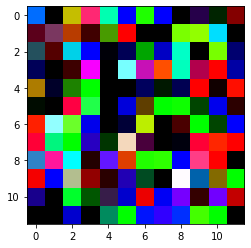

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline 

img = torch.randn(3, 12, 12)
# GPU 메모리에선 plt를 실행 못함 -> CPU로 불러옴
# 배치 차원을 날림
# 파이토치는 channel-first이므로 channel-last로 바꿈
plt.imshow(img.cpu().squeeze(dim=0).permute(1, 2, 0))

In [ ]:
for i in coach.data_loader:
  print(i[0], i[1])
  print(i[1].shape)
  plt.imshow(i[1].squeeze().cpu().squeeze(dim=0).permute(1, 2, 0))
  